In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
cd '/content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP'

/content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP


In [ ]:
!mkdir config datasets models

mkdir: cannot create directory ‘config’: File exists
mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘models’: File exists


In [ ]:
cd config

/content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP/config


In [ ]:
 #from google.colab import files
#iles.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"devanshi2804","key":"5b913c678281196b95da48e239073054"}'}

In [ ]:
cd '/content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP/datasets'

/content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP/datasets


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP/config"

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:32<00:00, 111MB/s] 
100% 2.70G/2.70G [00:32<00:00, 90.2MB/s]


In [ ]:
!ls

 content
'new plant diseases dataset(augmented)'
'New Plant Diseases Dataset(Augmented)'
 test


In [ ]:
#Unzipping the zip files to extract the dataset folder and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
for (root,dirs,files) in os.walk('.', topdown = True):
  print(root, dirs)

. ['New Plant Diseases Dataset(Augmented)', 'content', 'new plant diseases dataset(augmented)', 'test']
./New Plant Diseases Dataset(Augmented) ['New Plant Diseases Dataset(Augmented)']
./New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented) ['train', 'valid']
./New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train ['Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [ ]:
base_dir = './New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
os.listdir(base_dir)

['train', 'valid']

In [ ]:
len(os.listdir(os.path.join(base_dir, 'train')))

28

## Importing the required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from tensorflow.python import keras
import warnings
import argparse
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

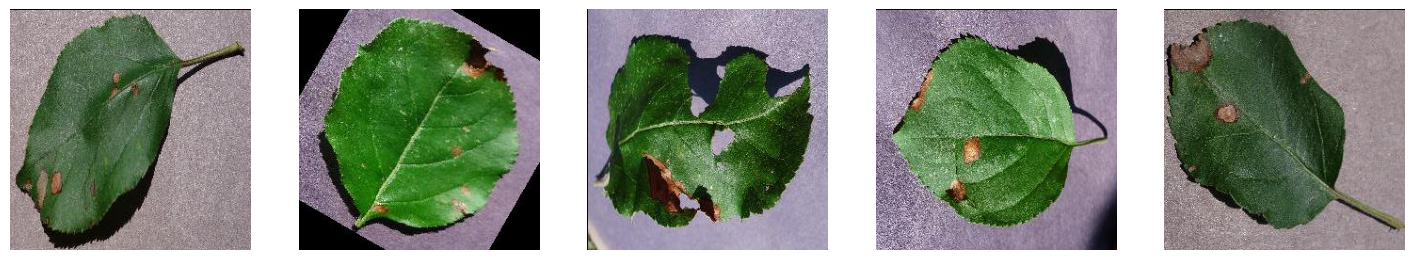

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18,18))
images = os.listdir(os.path.join(base_dir, 'train/Apple___Black_rot'))
for _ in range(5):
  ax = axes[_]
  image_path = base_dir+'/train/Apple___Black_rot/'+images[_]
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  ax.imshow(img)
  ax.axis('off')
plt.show()

## Data Augmentation transformations for the train dataset

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

# Data augmentation for validation dataset
validation_datagen = ImageDataGenerator(rescale = 1./255)

## Loading the images from their directories

In [ ]:
BATCH_SIZE = 32

train_set_from_dir = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'),
                                                       target_size = (224,224),
                                                       batch_size = BATCH_SIZE,
                                                       class_mode = 'categorical'
                                                       )

validation_set_from_dir = validation_datagen.flow_from_directory(os.path.join(base_dir, 'valid'),
                                                                 target_size = (224,224),
                                                                 batch_size = BATCH_SIZE,
                                                                 class_mode = 'categorical'
)

Found 52201 images belonging to 28 classes.
Found 13040 images belonging to 28 classes.


In [ ]:
classes_dict = train_set_from_dir.class_indices

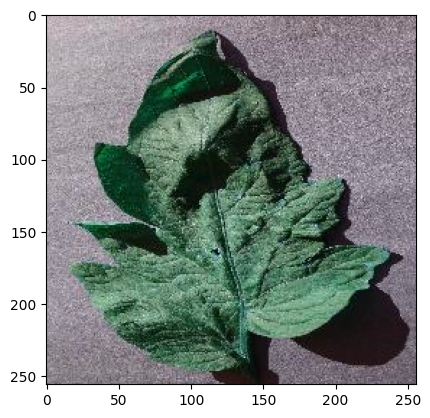

In [ ]:
img = train_set_from_dir.filepaths[np.random.random_integers(low=0, high=train_set_from_dir.samples)]
img = cv2.imread(img)
plt.imshow(img)

In [ ]:
import json
with open('/content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP/class_indices.json','w') as f:
  json.dump(classes_dict, f)

### Transfer learning with MobileNet architecture

In [ ]:

from keras import Input, Model
from keras.applications import MobileNet
from keras.layers import Flatten, Dense,Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, model_from_json
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
base_model = MobileNet(
    #Load weights into the pre-trained MobileNet model
    weights="imagenet",
    input_shape=(224, 224, 3),
    #Exclude the ImageNet classifier at the top of the model
    include_top=False
)

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
# Regularization by applying DropOut
head_model = Dropout(0.2)(head_model)
outputs = Dense(28, activation="softmax")(head_model)
mobilenet_model = Model(base_model.input, outputs, name='pretrained_mobilenet' )

for layer in mobilenet_model.layers:
    layer.trainable = False

# or if we want to set the first 20 layers of the network to be non-trainable
for layer in mobilenet_model.layers[:20]:
    layer.trainable=False
for layer in mobilenet_model.layers[20:]:
    layer.trainable=True

In [ ]:
# Compiling the model with the optimizer and loss function

mobilenet_model.compile(optimizer = Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)

In [ ]:
mobilenet_model.summary()
for idx, layer in enumerate(mobilenet_model.layers):
    print(idx, layer.name, layer.trainable)

Model: "pretrained_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 

In [ ]:
## Setting up callbacks for our model

callbacks = [
           ModelCheckpoint('content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP/checkpoints/mobilenet_plantdiseases.h5', save_best_only=True, monitor='val_acc'),
           EarlyStopping(monitor='val_loss', patience=2, verbose=1),
           ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1)
]

In [ ]:
N_EPOCHS = 10

history = mobilenet_model.fit(train_set_from_dir,
          validation_data = validation_set_from_dir,
          epochs = N_EPOCHS,
          # Use 128 random batches for training set
          steps_per_epoch = 128, # 128 x 32 = 2**12 random samples
          # Use 64 random batches for training validation set
          validation_steps = 100, # 100 x 32 = 3200 random samples
          callbacks = callbacks
          )

Epoch 1/10
112/128 [=========================>....] - ETA: 4:17 - loss: 0.3552 - accuracy: 0.8858

In [ ]:
n = 6
plt.figure(figsize = (8,5))
plt.plot(np.arange(1,n+1), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(1,n+1), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(1,n+1), history.history['accuracy'], label = 'train_accuracy')
plt.plot(np.arange(1,n+1), history.history['val_accuracy'], label = 'val_accuracy')

plt.grid(True)
plt.legend(loc = "best")
plt.savefig('/content/drive/My Drive/PLANT-DISEASE-CLASSIFIER-WEB-APP/performance.jpg')
plt.show()

NameError: ignored

<Figure size 800x500 with 0 Axes>

In [ ]:
# Evaluate the model on the Validation dataset
results = mobilenet_model.evaluate(validation_set_from_dir)

In [ ]:
print("Validation Loss :-", results[0])
print("="*30)
print("Validation Accuracy :-", results[1])

Validation Loss :- 0.014583874493837357
Validation Accuracy :- 0.8529478907585144


In [ ]:
cd '/content/drive/My Drive/PLANT DISEASE RECOGNITION'

In [ ]:
mkdir models

In [ ]:
# Save model in HDF5 format
mobilenet_model.save('/content/drive/My Drive/PLANT DISEASE RECOGNITION/models/mobilenet_model.h5')

In [ ]:
# Testing on a random image from the test images directory
from PIL import Image
np.random.seed(200)
idx = np.random.randint(30)
test_images_dir = os.path.join('datasets/test', 'test')
test1 = Image.open(os.path.join(test_images_dir, os.listdir(test_images_dir)[idx]))

In [ ]:
plt.imshow(test1)
plt.title(os.listdir(test_images_dir)[idx])

In [ ]:
test1 = test1.resize((224,224))
test1_scaled = np.expand_dims(np.asarray(test1), axis = 0) / 255
predictions = mobilenet_model.predict(test1_scaled)
print(predictions)

In [ ]:
classes_dict = train_set_from_dir.class_indices
classes_dict = { v:k for (k,v) in classes_dict.items() }
classes_dict[np.argmax(predictions)]

#### Accurate !

# Converting model to Tensorflow js

In [ ]:
!pip install tensorflowjs

In [ ]:
!pwd

In [ ]:
!mkdir tensorflowjs-model

In [ ]:
!tensorflowjs_converter --input_format keras models/mobilenet_model.h5 tensorflowjs-model/

In [ ]:
!zip -r tensorflowjs-model.zip tensorflowjs-model

## And we are done !

In [ ]:
!pip install flask

Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...


In [ ]:
!google-chrome --user-data-dir="~/chrome-dev-session" --disable-web-security
